In [39]:
import os
import pandas as pd
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import urllib

## 이미지 크롤링

In [2]:
beer_list = ['fitz super clear', 'TSINGTAO WHEAT BEER', 'Kozel Dark 10']
# beer_list = ['fitz super clear', 'TSINGTAO WHEAT BEER', 'Kozel Dark 10', 'OB premier pilsner', 'Hoegarden']

In [22]:
driver = webdriver.Chrome(r'/Users/juran/tool/chromedriver')

In [4]:
# 맥주명으로 폴더 생성 image/beer_name
def createFolder(directory):
    try:
        if not os.path.exists('image/' + directory):
            os.makedirs('image/' + directory)
    except OSError:
        print ('Error: Creating directory. ' + directory)

In [23]:
# 구글에서 맥주 이미지 크로링
def crawling(keyword):
    url = 'https://www.google.co.kr/imghp?hl=ko'
    driver.get(url)
    
    driver.find_element_by_xpath('//*[@id="sbtc"]/div/div[2]/input').send_keys(keyword + ' bottle')
    driver.find_element_by_xpath('//*[@id="sbtc"]/button').click()
    
    body = driver.find_element_by_tag_name("body")

    # 스크롤 내림
    for i in range(10):
        body.send_keys(Keys.PAGE_DOWN)
        time.sleep(0.1)
    
    # 폴더 생성
    createFolder(keyword)
    
    links=[]
    images = driver.find_elements_by_css_selector("img.rg_i.Q4LuWd")

    # 이미지 url
    for image in images:
        if image.get_attribute('src')!=None:
            links.append(image.get_attribute('src'))
    
    for k,i in enumerate(links[:120]):
        url = i
        start = time.time()
        urllib.request.urlretrieve(i, "./image/" + keyword +'/' +keyword+"_"+str(k)+".jpg")
        print(str(k+1)+'/'+str(len(links))+' '+keyword+' 다운로드 중....... Download time : '+str(time.time() - start)[:5]+' 초')
        print(keyword + ' ---다운로드 완료---')
        time.sleep(1)

In [1]:
for beer in beer_list:
    crawling(beer)

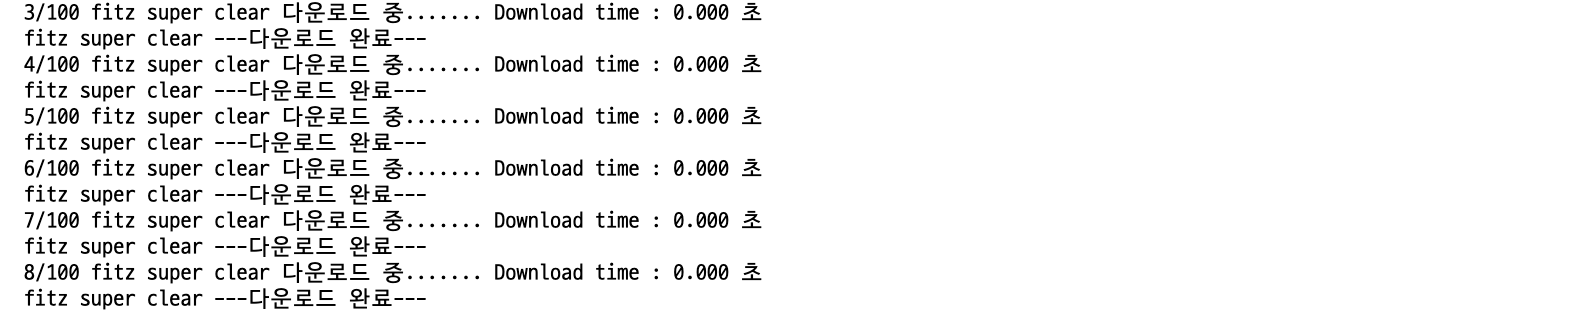

In [25]:
driver.close()
driver.quit()

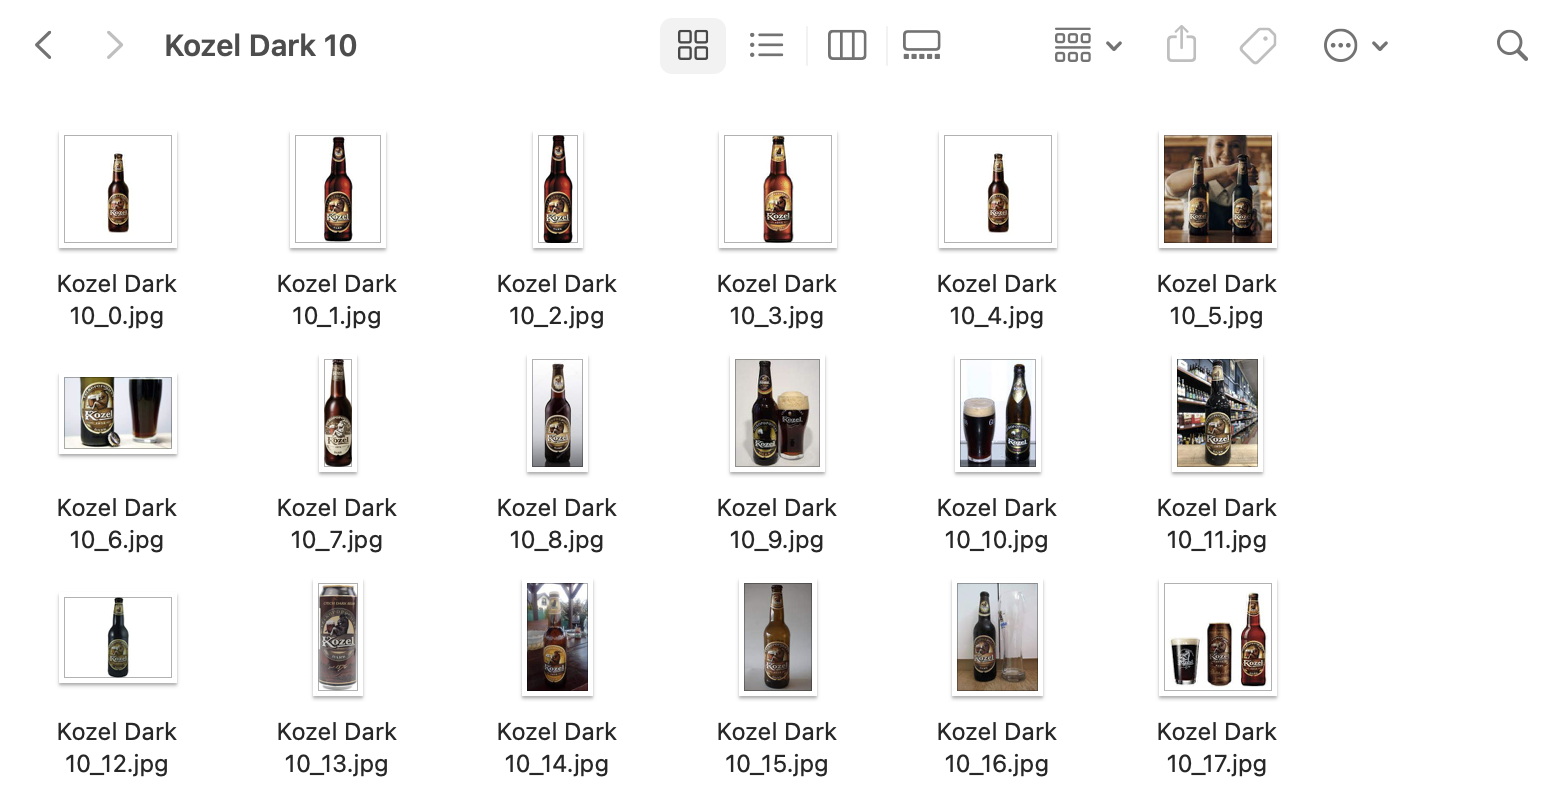

<br>

## YOLO (Object Detection)

In [2]:
import cv2
import numpy as np

In [3]:
# Yolo 로드
net = cv2.dnn.readNet("yolo/yolov3.weights", "yolo/yolov3.cfg")
classes = []

with open("yolo/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [21]:
# 이미지 가져오기
img_ttl = 'Kozel Dark 10_19'
img_path = "image/Kozel Dark 10/" + img_ttl + ".jpg"
img = cv2.imread(img_path)
height, width, channels = img.shape

In [22]:
# Detecting objects
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
net.setInput(blob)
outs = net.forward(output_layers)

In [23]:
# 정보를 화면에 표시
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            # 좌표
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [24]:
# Non maximum suppresion 노이즈 제거(같은 물체에 대한 박스가 많은 것 제거)
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

In [25]:
font = cv2.FONT_HERSHEY_PLAIN
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = colors[i]
        # 물체 사각형
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        # 물체명
        cv2.putText(img, label, (x, y + 30), font, 3, color, 3)
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# 종료 - 이미지 윈도우에서 ctrl+c

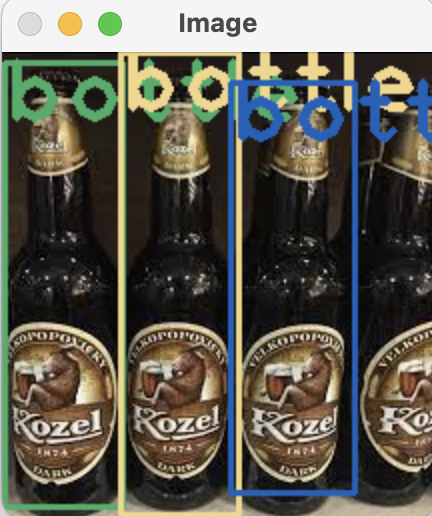

In [36]:
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        print('x {} / y {} / x+w {} / y+h {}'.format(x, y, x + w, y + h))

x 1 / y 5 / x+w 60 / y+h 227
x 59 / y 0 / x+w 118 / y+h 231
x 114 / y 15 / x+w 176 / y+h 220


In [29]:
from PIL import Image

image = Image.open("image/Kozel Dark 10/" + img_ttl + ".jpg")
 
#이미지의 크기 출력
print(image1.size)

(217, 233)


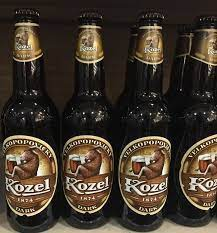

In [33]:
img_ttl

'Kozel Dark 10_19'

In [37]:
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        croppedImage = image.crop((x, y, x + w, y + h))
        print("잘려진 사진 크기 :", croppedImage.size)
        croppedImage.save("image/Kozel Dark 10/" + img_ttl + '_' + str(i) + ".jpg")

잘려진 사진 크기 : (59, 222)
잘려진 사진 크기 : (59, 231)
잘려진 사진 크기 : (62, 205)


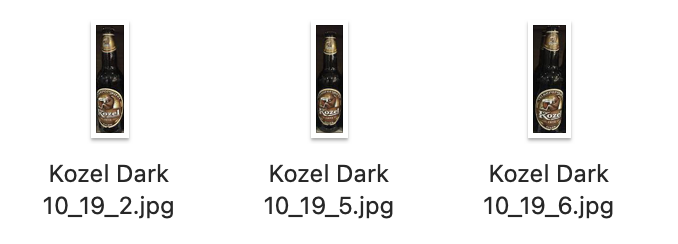

In [42]:
# 물체 분류 후 해당 이미지 삭제
img_path = "image/Kozel Dark 10/" + img_ttl + ".jpg"
os.remove(img_path)

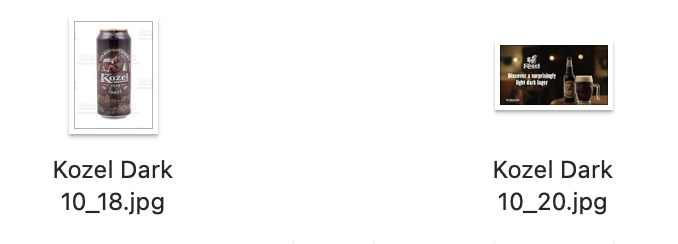